# NYC AirBnb

I often stay at AirBnb since it is very easy to book and provides good places to stay. AirBnb data is not publicly available, but Inside Airbnb had scraped the listing data from the AirBnb and make it publicly available. There aren't many cities available though. 

http://insideairbnb.com/get-the-data.html

In [2]:
## Load Necessary libraries

import pylab as pl
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame

%pylab inline

import urllib

Populating the interactive namespace from numpy and matplotlib


In [3]:
!curl http://data.insideairbnb.com/united-states/ny/new-york-city/2018-10-03/visualisations/listings.csv > nycbnb.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7907k  100 7907k    0     0  32.7M      0 --:--:-- --:--:-- --:--:-- 32.8M


In [3]:
nycbnb = pd.read_csv("nycbnb.csv")
nycbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2515,Stay at Chez Chic budget room #1,2758,Steph,Manhattan,Harlem,40.799205,-73.953676,Private room,59,2,173,2018-09-18,1.42,3,310
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647486,-73.972370,Private room,149,1,8,2018-07-17,0.23,8,360
2,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.753621,-73.983774,Entire home/apt,225,1,36,2018-10-01,0.33,2,345
3,3330,++ Brooklyn Penthouse Guestroom ++,4177,Jbee,Brooklyn,Williamsburg,40.708558,-73.942362,Private room,70,5,34,2018-09-16,0.32,3,271
4,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809018,-73.941902,Private room,150,3,0,NaN,NaN,1,365


In [4]:
# work with coordinate data
import shapely

nycbnb['lonlat']=list(zip(nycbnb.longitude,nycbnb.latitude))
# Create Point Geometry for based on lonlat column
nycbnb['geometry']=nycbnb[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [91]:
nycshape = GeoDataFrame(nycbnb)

In [6]:
nycshape.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'lonlat', 'geometry'],
      dtype='object')

In [92]:
import fiona
nycshape.crs = fiona.crs.from_epsg(2263)
nycshape.price = nycshape.price.astype(int)

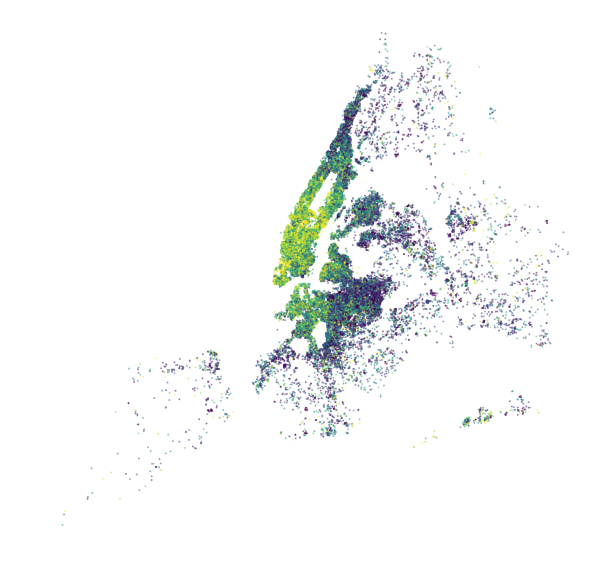

In [115]:
f, ax = pl.subplots(figsize=(10,10))
ax.axis('off')
nycshape.plot(column = 'price', cmap = "viridis",ax = ax,  markersize = 1, scheme ="Quantiles", alpha= 0.4, k = 8)

### Get Neighborhood Shape

In [10]:
!wget http://data.insideairbnb.com/united-states/ny/new-york-city/2018-10-03/visualisations/neighbourhoods.geojson

--2018-11-04 22:36:48--  http://data.insideairbnb.com/united-states/ny/new-york-city/2018-10-03/visualisations/neighbourhoods.geojson
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.162.202
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.162.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 634167 (619K) [application/octet-stream]
Saving to: ‘neighbourhoods.geojson’

neighbourhoods.geoj 100%[===================>] 619.30K  --.-KB/s    in 0.01s   

2018-11-04 22:36:48 (42.2 MB/s) - ‘neighbourhoods.geojson’ saved [634167/634167]



In [94]:
neighborhood = gpd.read_file("neighbourhoods.geojson")

In [95]:
neighborhood.head()

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"(POLYGON ((-73.76670799999999 40.614911, -73.7..."
1,Allerton,Bronx,"(POLYGON ((-73.848597 40.87167, -73.845823 40...."
2,City Island,Bronx,"(POLYGON ((-73.782822 40.843919, -73.782572 40..."
3,Ditmars Steinway,Queens,"(POLYGON ((-73.90160299999999 40.76777, -73.90..."
4,Ozone Park,Queens,"(POLYGON ((-73.83754399999999 40.691364, -73.8..."


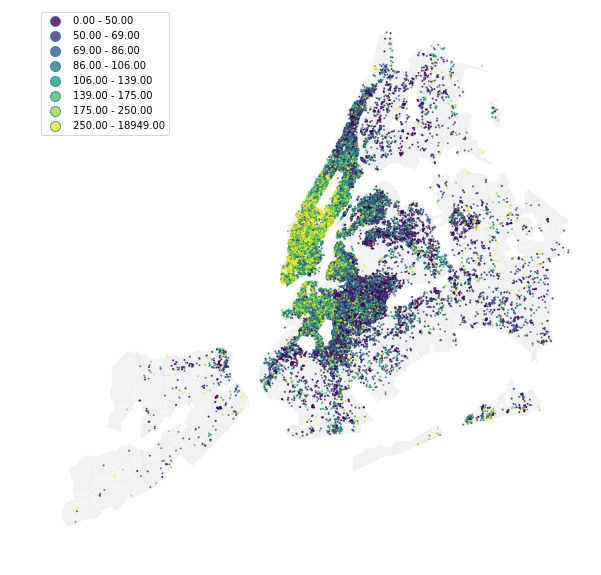

In [114]:
f, ax = pl.subplots(figsize=(10,10))
ax.axis('off')
neighborhood.plot(alpha=0.1,linewidth=0.5,ax=ax,color="grey", edgecolor="darkgrey")
nycshape.plot(column = 'price', cmap = "viridis",ax = ax,  markersize = 1, scheme ="Quantiles", alpha= 0.8, legend = True, k = 8)

#### Now that looks cool, but it doesnt seems aesthetic enough for me, so lets focus on manhattan area

### Separate by Borough

In [65]:
boro = nycshape.neighbourhood_group.unique()
print(boro)

['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island']


In [104]:
for i in boro:
    globals()[i] = nycshape.loc[nycshape['neighbourhood_group'] ==  i]

#### I want to rotate the map so that Manhattan is plotted vertically

In [105]:
# rotate the geodataframe
MN = Manhattan
MN.geometry= Manhattan.geometry.rotate(35,origin=(Manhattan.latitude.mean(),Manhattan.longitude.mean()))

#### Lets make two visualizations, one is each Airbnb is represented by their price using color and the other one is represented by the price using color and monthly review using the point size. 

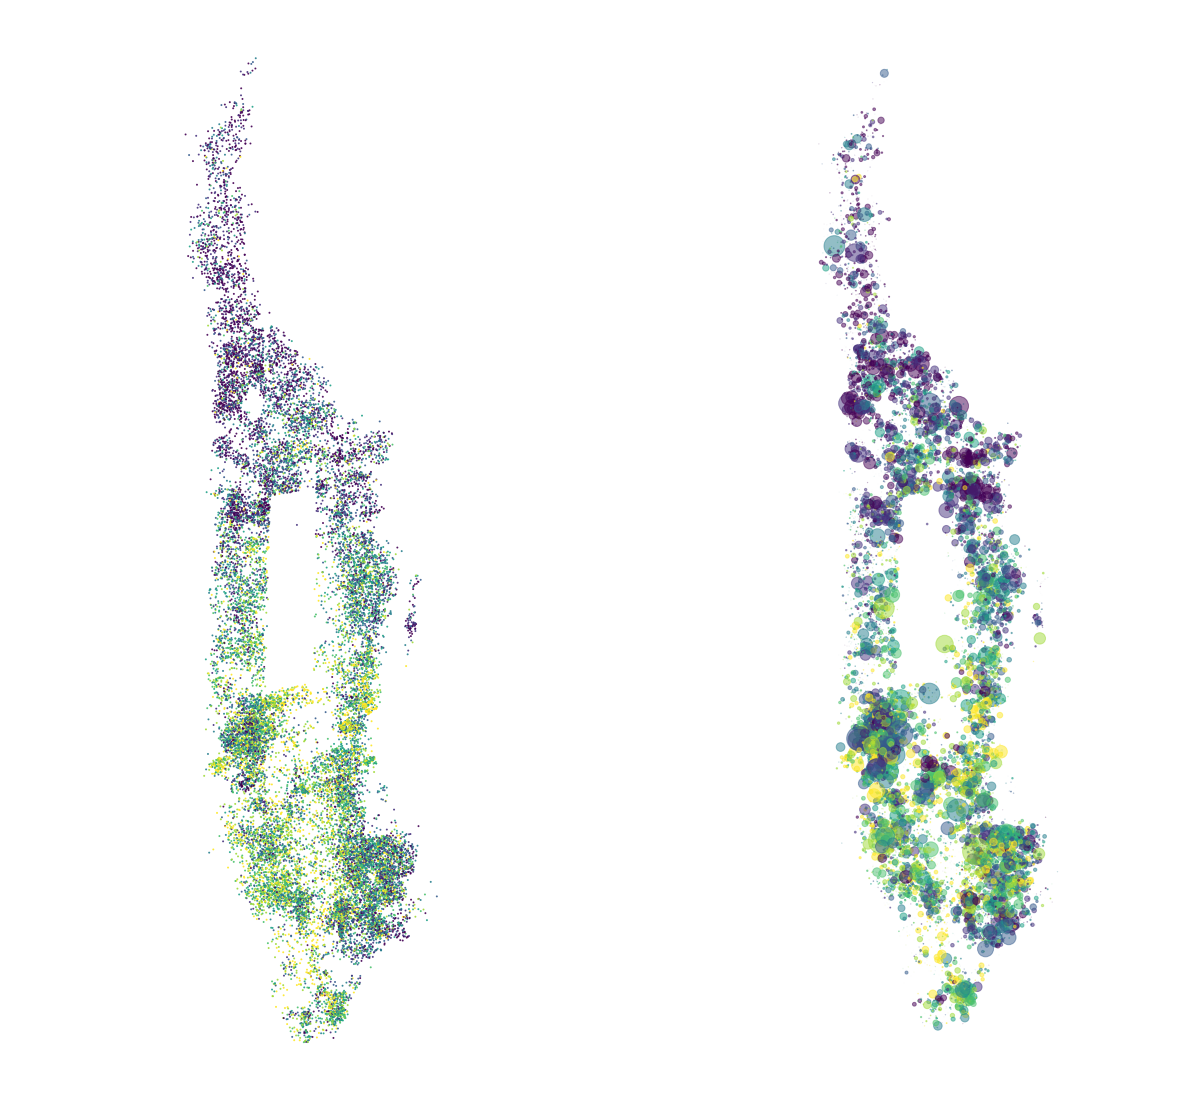

In [127]:
f, (ax1, ax2) = pl.subplots(nrows=1, ncols=2,figsize=(20,20))

ax1.axis('off')
ax2.axis('off')

ax1 = MN.plot(column = 'price', cmap = "viridis", ax = ax1, alpha = 0.8,  
               markersize = 1, 
               scheme ="Quantiles", k = 8)

ax2 = MN.plot(column = 'price', cmap = "viridis", ax = ax2, alpha = 0.5,  
               markersize = (Manhattan['reviews_per_month']/Manhattan['reviews_per_month'].mean())**3, 
               scheme ="Quantiles", k = 8)

ax1.axes.set_aspect('equal', 'datalim')
ax2.axes.set_aspect('equal', 'datalim')

### Lets do the Whole Thing But only focused on Manhattan

In [199]:
shapebnb = nycshape.loc[(nycshape['neighbourhood_group'].isin(["Manhattan", "Brooklyn", "Queens"]))]
shapebnb.geometry= shapebnb.geometry.rotate(35,origin=(shapebnb.latitude.mean(),shapebnb.longitude.mean()))

In [192]:
shapebnbMN = shapebnb.loc[shapebnb['neighbourhood_group'] == "Manhattan"]

In [213]:
minx, miny, maxx, maxy = shapebnbMN.total_bounds
print(minx, maxx)

-74.01844933310545 -73.90855000582128


[None, None]

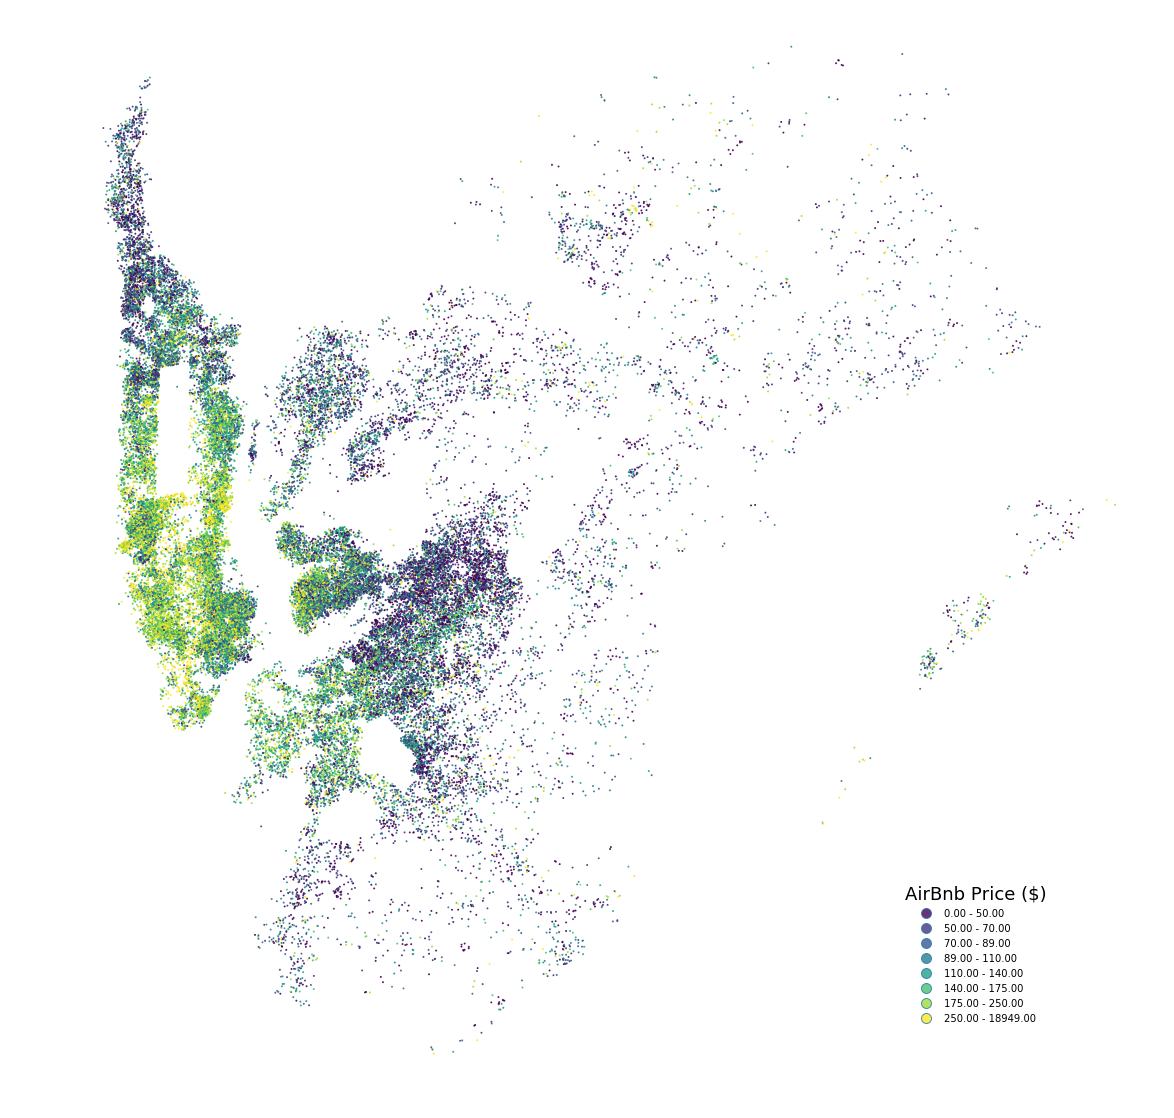

In [269]:
f, ax = pl.subplots(figsize=(20,20))
ax.axis('off')
ax = shapebnb.plot(column = 'price', cmap = "viridis",ax = ax,  markersize = 1, scheme ="Quantiles", alpha= 0.8, k = 8, legend = True)
ax.axes.set_aspect('equal', 'datalim')

leg = ax.get_legend()
leg.set_title("AirBnb Price ($)" )
leg.set_bbox_to_anchor((0.2, 0., 0.7, 0.2))

leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_facecolor('none')

plt.setp(leg.get_title(),fontsize=18)

Text(0.5, 1.0, '')

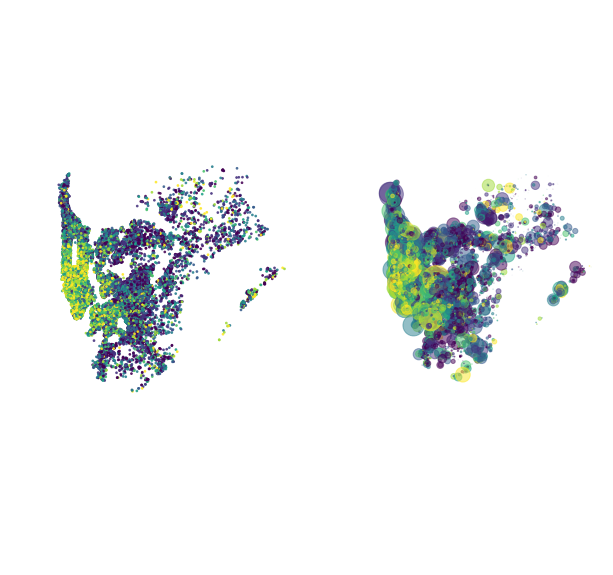

In [203]:
f, (ax1, ax2) = pl.subplots(nrows=1, ncols=2,figsize=(20,20))

ax1.axis('off')
ax2.axis('off')

ax1 = shapebnb.plot(column = 'price', cmap = "viridis", ax = ax1, alpha = 0.8,  
               markersize = 3, 
               scheme ="Quantiles", k = 8)

ax2 = shapebnb.plot(column = 'price', cmap = "viridis", ax = ax2, alpha = 0.5,  
               markersize = (Manhattan['reviews_per_month']/Manhattan['reviews_per_month'].mean())**3, 
               scheme ="Quantiles", k = 8)

ax1.axes.set_aspect('equal', 'datalim')
ax2.axes.set_aspect('equal', 'datalim')

ax1.set_title("")

ax1.set_xlim(minx, maxx)
ax1.set_ylim(miny, maxy)

ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)